In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
import tensorflow as tf

disable_eager_execution()  # for graph mode
tf.compat.v1.experimental.output_all_intermediates(True)

In [3]:
from time_series.dataset.utils import get_energy_demand
from time_series.dataset.time_series import TrainingDataSet

train_df = get_energy_demand()
tds = TrainingDataSet(train_df.head(500))

In [5]:
from time_series.models.deepar import DeepAR

ar_model = DeepAR(tds, epochs=100)
ar_model.instantiate_and_fit(verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 4)             240       
_________________________________________________________________
dense (Dense)                (None, 10, 4)             20        
_________________________________________________________________
main_output (GaussianLayer)  [(None, 10, 10), (None, 1 100       
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________
Train on 400 samples
Epoch 1/100
400/400 [==============================] - 1s 3ms/sample - loss: 1.4354 - mean_absolute_percentage_error: 181.5182 - mae: 0.7557 - mse: 0.7950

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def evaluate_model(tds=tds, first_n=0):
    dimensions = len(train_df.columns)
    plt.figure(figsize=(12, 18))
    grid = plt.GridSpec(dimensions, 1 if first_n else 2, wspace=0.5, hspace=0.2)

    for i in range(dimensions):    
        y_pred, y_actual = y_predicted[:, i, 0], tds.y_test[:, i, 0]
        ax = plt.subplot(grid[i, 0])
        if first_n:
            y_pred, y_actual = y_pred[:first_n], y_actual[:first_n]
            plt.plot(y_pred, 'r+--', label="predicted")
            plt.plot(y_actual, 'bo-.', label="actual")
        else:
            plt.plot(y_pred)
            plt.subplot(grid[i, 1])
            plt.plot(y_actual)
        ax.set_title(list(train_df.columns)[i])
        print(f"{train_df.columns[i]}: {round(mean_squared_error(y_actual, y_pred), 2)}")
    if first_n:
        plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CT: 0.18
MASS: 0.09
ME: 0.15
NEMASSBOST: 0.12
NH: 0.59
RI: 0.11
SEMASS: 0.17
TOTAL: 0.11
VT: 0.17
WCMASS: 0.16


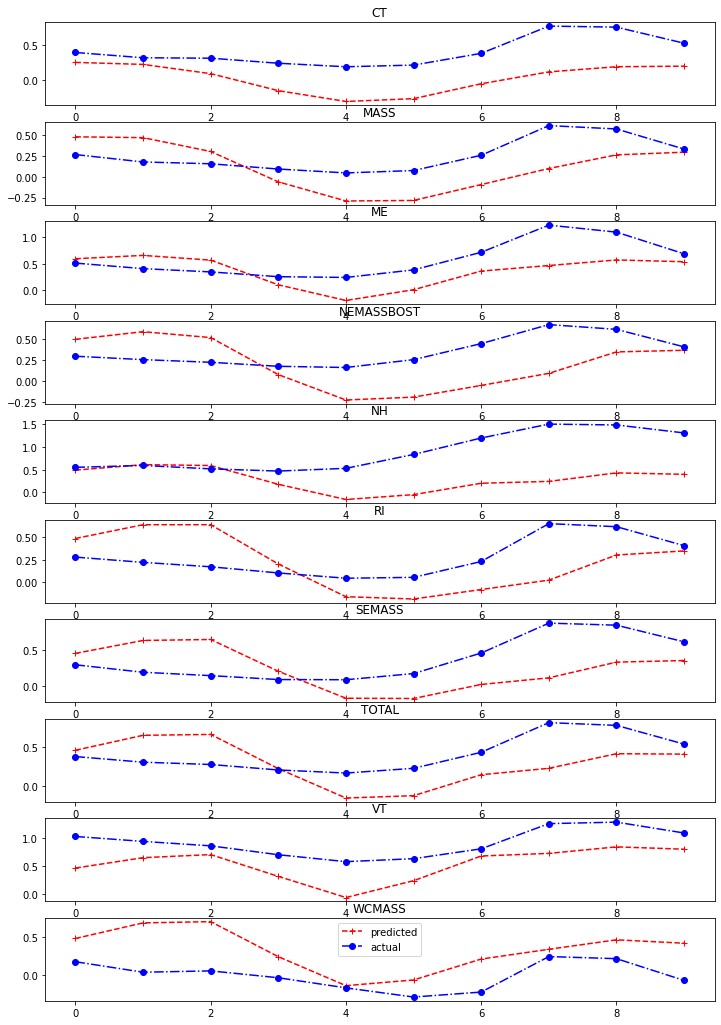

In [7]:
# print(dp_model.keras_model.evaluate(dp_model.X_test, dp_model.y_test))
y_predicted = ar_model.predict(tds.X_test, steps=10)
evaluate_model(first_n=10)

In [22]:
from time_series.models.nbeats import NBeatsNet

nb = NBeatsNet(tds)
nb.instantiate_and_fit(verbose=1, epochs=1)

Train on 400 samples
400/400 [==============================] - 11s 27ms/sample - loss: 0.8111


CT: 0.45
MASS: 0.34
ME: 1.02
NEMASSBOST: 0.51
NH: 1.84
RI: 0.58
SEMASS: 0.73
TOTAL: 0.41
VT: 0.93
WCMASS: 0.21


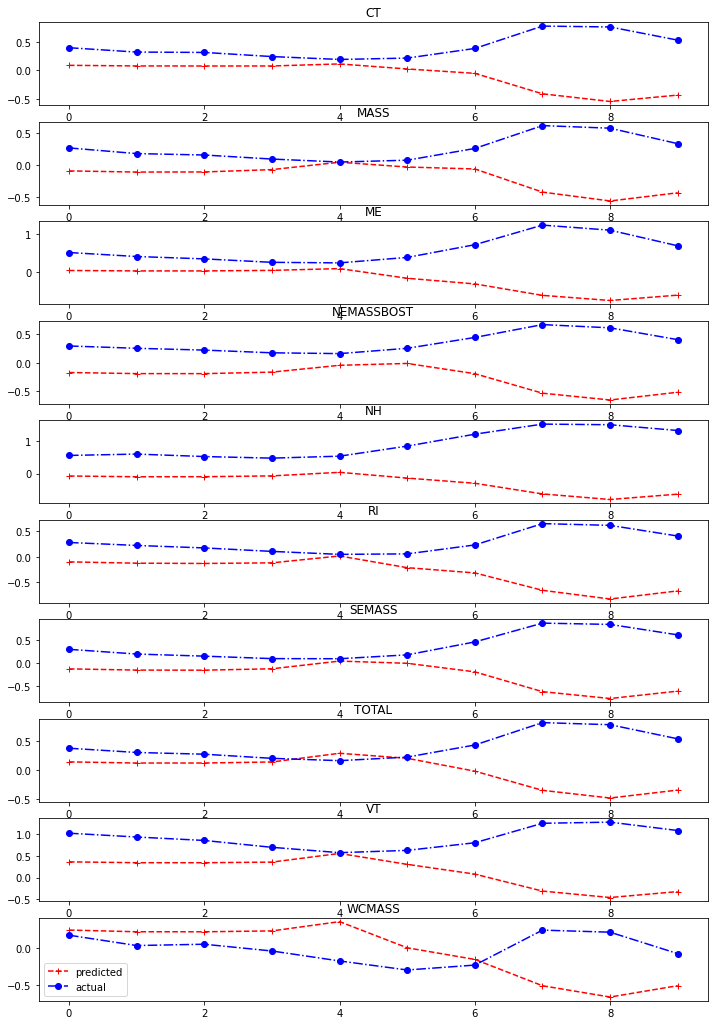

In [27]:
y_predicted = nb.model.predict(tds.X_test, steps=10)
evaluate_model(first_n=10)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 10, 10)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 100)           44400     
_________________________________________________________________
dense_37 (Dense)             (None, 10, 10)            1010      
Total params: 45,410
Trainable params: 45,410
Non-trainable params: 0
_________________________________________________________________
None
Train on 400 samples
Epoch 1/10
400/400 [==============================] - 1s 4ms/sample - loss: 0.7167 - mean_absolute_percentage_error: 133.9230 - mae: 0.7269 - mse: 0.7167

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CT: 0.2
MASS: 0.09
ME: 0.35
NEMASSBOST: 0.08
NH: 0.7
RI: 0.06
SEMASS: 0.1
TOTAL: 0.09
VT: 0.5
WCMASS: 0.16


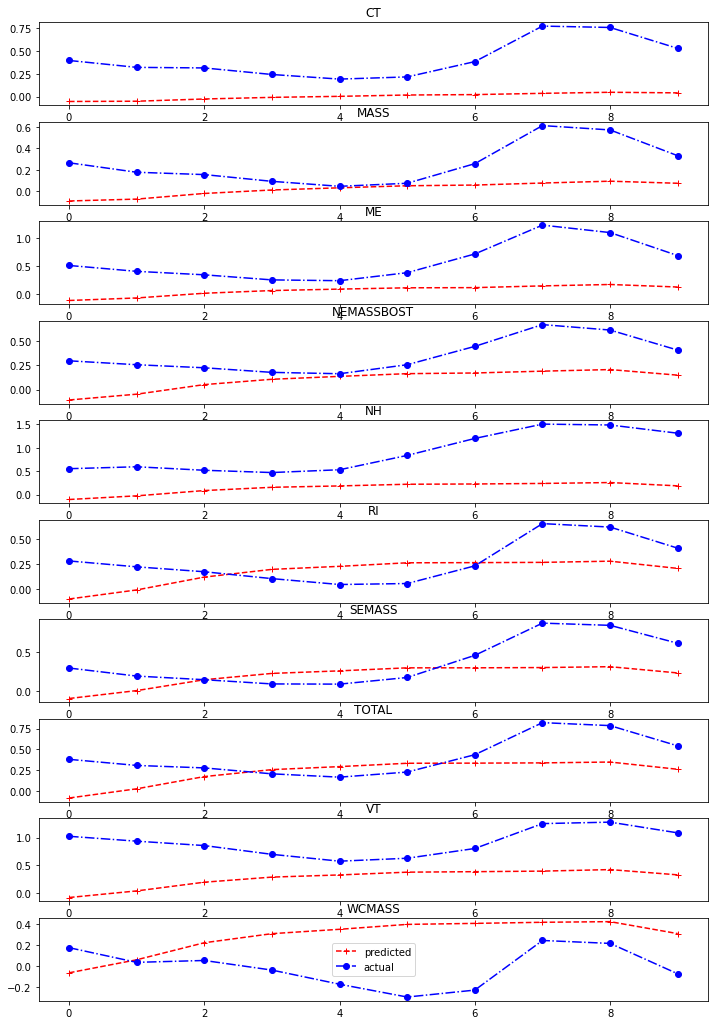

In [44]:
from time_series.models.LSTM import LSTM
lstm = LSTM(tds)
lstm.instantiate_and_fit(verbose=1, epochs=10)
y_predicted = lstm.model.predict(tds.X_test, steps=10)
evaluate_model(first_n=10)

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
multi_head_attention_20 (MultiH (None, 10, 10)       22026       input_27[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 10, 10)       0           multi_head_attention_20[0][0]    
__________________________________________________________________________________________________
layer_normalization_35 (LayerNo (None, 10, 10)       20          dropout_77[0][0]          

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CT: 0.08
MASS: 0.08
ME: 0.38
NEMASSBOST: 0.09
NH: 0.84
RI: 0.12
SEMASS: 0.14
TOTAL: 0.16
VT: 0.47
WCMASS: 0.03


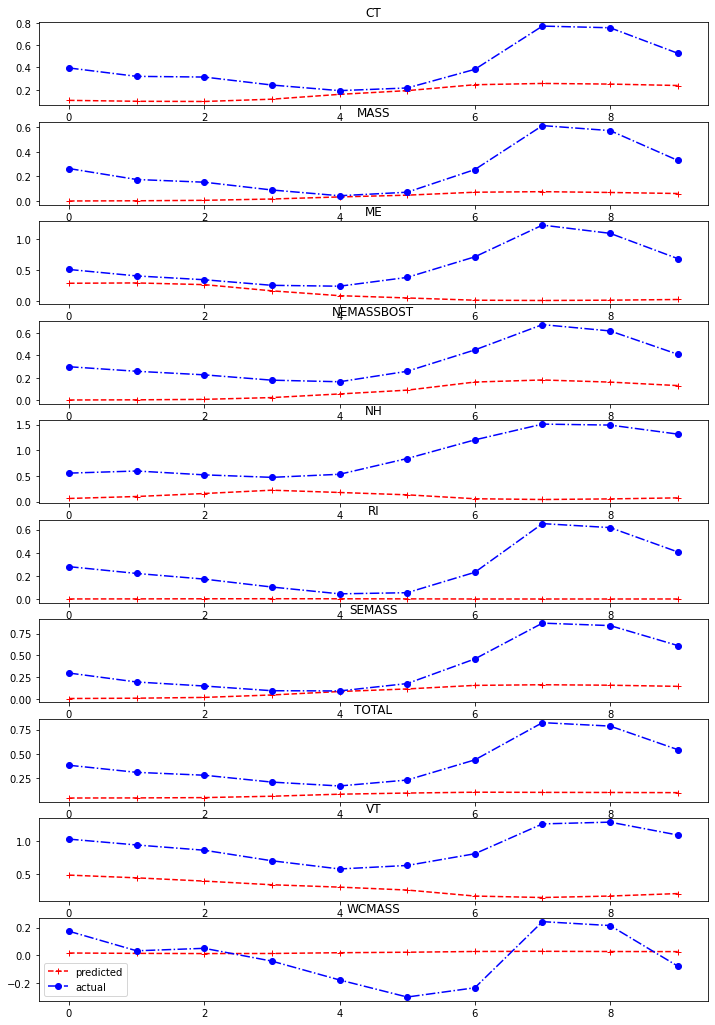

In [53]:
# only training a 1-step prediction here:
from time_series.models.transformer import Transformer

tds_1step = TrainingDataSet(train_df.head(500), lag=1, two_dim=False)
tds_1step.X_test = tds.X_test
tds_1step.X_train = tds.X_train
trans = Transformer(tds_1step)
trans.instantiate_and_fit(verbose=1, epochs=100)
y_predicted = trans.model.predict(tds.X_test, steps=10)
evaluate_model(first_n=10)

In [52]:
# this only works in Eager mode!
from time_series.models.gaussian_process import GaussianProcess
tds2d = TrainingDataSet(train_df.head(500), two_dim=True)
gp = GaussianProcess(tds2d)
gp.instantiate_and_fit(maxiter=1)


(900, 10, 1)

CT: 0.19
MASS: 0.33
ME: 0.28
NEMASSBOST: 0.21
NH: 0.45
RI: 0.15
SEMASS: 0.19
TOTAL: 0.27
VT: 1.17
WCMASS: 0.5


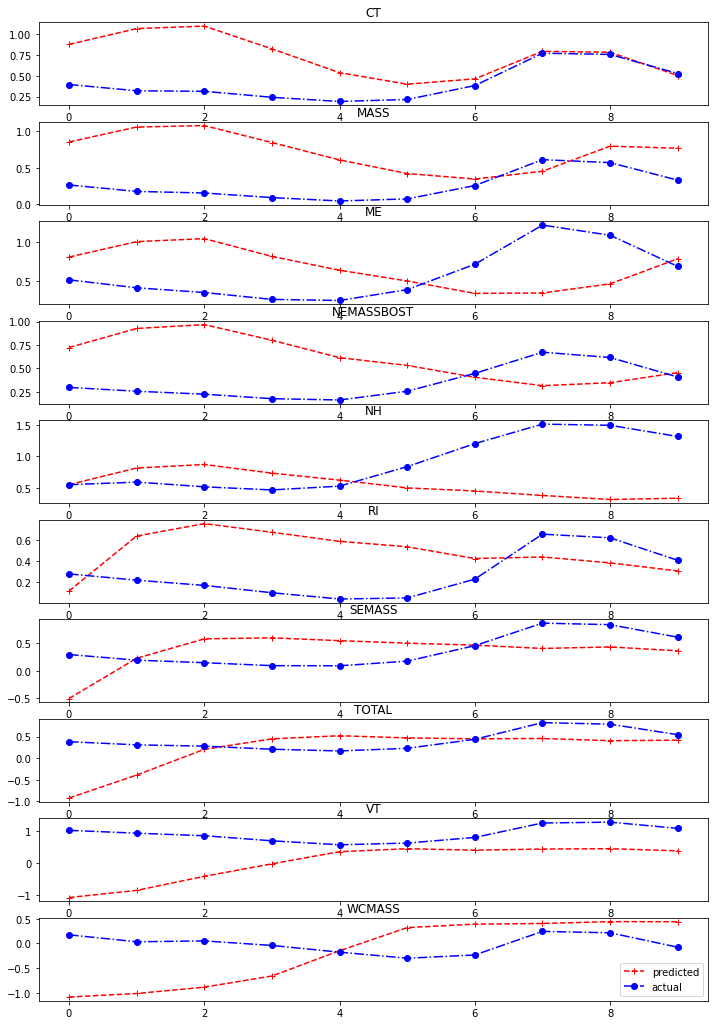

In [29]:
y_predicted = gp.predict(tds2d.X_test)[0].numpy().reshape(-1, tds.dimensions, tds.n_steps)#%%
evaluate_model(first_n=10)